# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *H*

**Names:**

* *BAFFOU Jérémy*
* *BASSETO Antoine*
* *PINTO Andrea*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

# 2.1 Exploration of real networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.stats import linregress
import os
import json

## Exercise 2.1

Your first task is to explore network1 and analyze its properties.
1. Load the graph in your favorite data structure.
2. How many nodes and edges does the graph contain?

### Load the dataset into PD dataframe and convert into NX

In [2]:
network1_df = pd.read_csv("../data/network1.csv", skiprows=2, names=['from', 'to'])

In [3]:
network1_df.tail()

,from,to
18579,12741,12974
18580,12775,12935
18581,12783,12850
18582,12850,12854
18583,12983,13024


In [4]:
G = nx.from_pandas_edgelist(network1_df, 'from', 'to')

In [5]:
print(f'There are {len(list(G.nodes))} nodes in network1 !')
print(f'There are {len(list(G.edges))} edges in network1 !')

There are 13033 nodes in network1 !
There are 18584 edges in network1 !


## Exercise 2.2:  Node degree distribution
A convenient way to start exploring the structure of a graph is through its node degree distribution. <br>
Compute the node degree distribution of network1 and visualize it.

1. What kind of plot do you think is useful for this task?
2. Can you list some of the properties of the degree distribution?
3. Is it close to a well-known probability distribution? If so, provide an estimation of its
parameter(s)?
􏰀

In [6]:
# List of degrees for each node in the graph
degrees = np.array([degree for node, degree in G.degree])

In [7]:
# Indices of the nodes in decreasing order w.r.t their degree
indices = np.argsort(degrees)[::-1]

### Print first results

In [8]:
# Print the first 5 nodes and their corresponding degree
nodes_degree = ["%6d %6d" % (a, b) for a, b in zip(indices, degrees[indices])][:5]
print("%6s %6s" % ("Node", "Degree"))
print('\n'.join(nodes_degree))

  Node Degree
     9   1482
    23   1083
    20    691
     5    619
   126    467


### Plot histogram of the node degree distribution

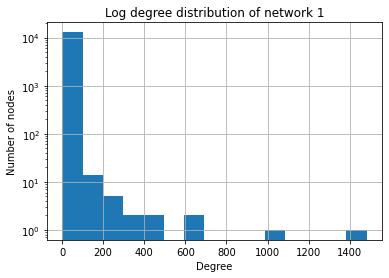

In [9]:
plt.hist(degrees, bins=15)
plt.yscale('log')
plt.title("Log degree distribution of network 1")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

### Plot another view of the node degree distribution

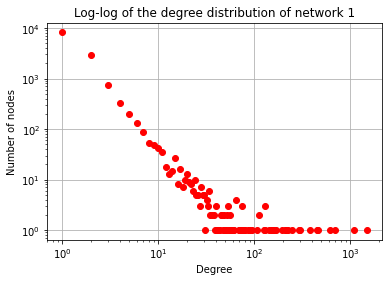

In [11]:
plt.plot(np.bincount(degrees), 'ro')
plt.xscale('log')
plt.yscale('log')
plt.title("Log-log of the degree distribution of network 1")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

### Compute CCDF of the node degree distribution

In [12]:
ccdf = 1 - np.cumsum(np.bincount(degrees)) / len(list(G.nodes))

### Plot CCDF of the node degree distribution

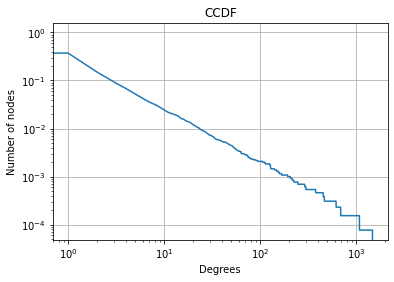

In [13]:
plt.plot(ccdf)
plt.xscale('log')
plt.yscale('log')
plt.title("CCDF")
plt.xlabel("Degrees")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

### Compute some properties

In [14]:
mean = np.mean(degrees)
std  = np.std(degrees)
var  = std * std

In [15]:
print(f'Degree distribution has \n \t mean : {mean} \n \t std  : {std} \n \t var  : {var}')

Degree distribution has 
 	 mean : 2.8518376429064682 
 	 std  : 20.859853773744813 
 	 var  : 435.1334994620157


In [16]:
slope, intercept, r_value, p_value, std_err = linregress(np.log10(np.array(range(0, max(degrees)+1))+1), np.log10(ccdf + 1))

In [17]:
slope

-0.007002480299341072

### Answers to questions

1. What kind of plot do you think is useful for this task? <br>
The best plot to recognize if the node degree distribution is a power law or not is the histogram of the **log-log plot of the CCDF**.
2. Can you list some of the properties of the degree distribution? <br>
See *mean*, *std* and *var* above.
3. Is it close to a well-known probability distribution? If so, provide an estimation of its parameter(s)? 􏰀<br>
It is close to Pareto distribution. But we are in discrete environment and its discrete analog is the **zeta distribution**. <br>

## Exercise 2.3: Giant component
Real networks are generally not connected, but one connected component, i.e., the giant component, is usually much larger than the others.
1. Count the number of connected components in network1.
2. Is there a giant component ? If so, what is its size?

In [18]:
cc = list(nx.connected_components(G))

In [19]:
print(f'There are {len(cc)} components in network1')

There are 192 components in network1


In [20]:
# Store cc in a deacreasing order list
sorted_cc = sorted(cc, key=len)[::-1]

In [21]:
dict_cc = ["%6d \t %6d" % (i + 1, len(sorted_cc[i])) for i in range(len(sorted_cc))][:5]
print("%6s \t %6s" % ("CC", "# Nodes"))
print('\n'.join(dict_cc))

    CC 	 # Nodes
     1 	  12576
     2 	     16
     3 	      7
     4 	      6
     5 	      5


In [22]:
print(f"The giant cc contains {100 * len(sorted_cc[0]) / len(list(G.nodes))} % of the network's nodes with {len(sorted_cc[0])} nodes out of {len(list(G.nodes))}.")

The giant cc contains 96.49351645822144 % of the network's nodes with 12576 nodes out of 13033.


## Exercise 2.4: Short paths & Small-worlds
In his book “Six Degrees” (2006), Duncan Watts explains the small-world effect by the now famous claim that every human on our planet is connected by an average of only “six degrees of separation”. Do you think that network1 is a small-world? Justify your answer.
Hint:
- What is the distribution of path lengths between any two nodes in the network?
- How fast is the network growing? I.e. what is the average number of nodes reachable
within a distance r (in number of hops) of any other node in the network?

### Compute the shortest path length from every pair of node in G

In [ ]:
dist = dict(nx.shortest_path_length(G))

In [ ]:
df_dist = pd.DataFrame(dist)

### Explore the DF

In [ ]:
df_dist.head()

In [ ]:
df_dist.tail()

### Parse NaN values
For further analysis, we decided to cast the NaN values to -1 values. Because no path is of length -1, this convention poses no design problems.

In [ ]:
df = df_dist.replace(np.NaN, -1)

### Compute distribution of path length

We decided to compute the distribution for path length up to 28 (see below for the justification). Note that $\forall i \in [0,28]$ you will find the number of path between any two nodes in the graph G of length $i$  at index $i$. Furthermore you will find the number of *impossible paths* (convention -1) at index $i = 29$.

In [ ]:
distribution = np.zeros(30) # index 0:0, 1:1, ... , 28 : 28, 29 : -1

for i in range(df.shape[1]):
    serie = df[i].value_counts()
    for l in serie.index:
        distribution[int(l)] += serie[l]

#### Justification for the maximum path length considered in the distribution

Below we prove that all shortest paths existing in the graph G have been taken into account in our distribution of path lengths. Indeed, the number of shortest paths is exactly the same as the number of paths in our distribution. Number of shortest paths is easily computed as the number of nodes squared. 

In [ ]:
print(f'Real total number of paths in the graph G : {len(list(G.nodes))**2}')
print(f'Number of paths considered in our distribution : {np.sum(distribution)}')

In [ ]:
plt.plot(distribution, 'ro')

### Network growth analysis (CDF)

In [ ]:
growth = np.cumsum(distribution)

In [ ]:
plt.plot(growth, 'ro')

### Is network 1 a *small world* ?!

***YES IT IS.*** As it can be seen in the above plots almost every nodes can be reached in 6 degrees or less from every node in the graph.

## Exercise 2.5: Network comparison
You will now focus on a second real network network2.csv located in the data/ folder.
1. Using the properties computed in Exercises 2.1, 2.2, 2.3 and 2.4 explore the structure of this network.
2. How does this network differ from the previous one?

In [23]:
network2_df = pd.read_csv("../data/network2.csv", skiprows=2, names=['from', 'to'])

In [24]:
G2 = nx.from_pandas_edgelist(network2_df, 'from', 'to')

In [25]:
print(f'There are {len(list(G2.nodes))} nodes in network2 !')
print(f'There are {len(list(G2.edges))} edges in network2 !')

There are 26542 nodes in network2 !
There are 43516 edges in network2 !


In [26]:
# List of degrees for each node in the graph
degrees2 = np.array([degree for node, degree in G2.degree])

In [27]:
# Indices of the nodes in decreasing order w.r.t their degree
indices2 = np.argsort(degrees2)[::-1]

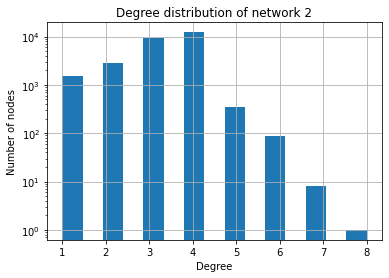

In [41]:
plt.hist(degrees2, bins=15)
plt.yscale('log')
plt.title("Degree distribution of network 2")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

### Another view of the distribution

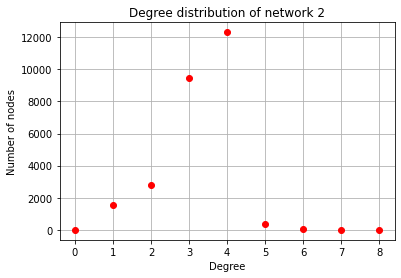

In [35]:
plt.plot(np.bincount(degrees2), 'ro')
plt.title("Degree distribution of network 2")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

In [42]:
mean2 = np.mean(degrees2)
std2  = np.std(degrees2)
var2  = std2 * std2

In [43]:
print(f'Degree distribution has \n \t mean : {mean2} \n \t std  : {std2} \n \t var  : {var2}')

Degree distribution has 
 	 mean : 3.2790294627383014 
 	 std  : 0.90164134609217 
 	 var  : 0.8129571169829002


In [44]:
ccdf2 = 1 - np.cumsum(np.bincount(degrees2)) / len(list(G2.nodes))

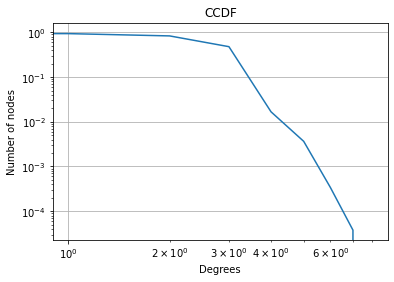

In [45]:
plt.plot(ccdf2)
plt.xscale('log')
plt.yscale('log')
plt.title("CCDF")
plt.xlabel("Degrees")
plt.ylabel("Number of nodes")
plt.grid()
plt.show()

In [46]:
cc2 = list(nx.connected_components(G2))

In [47]:
print(f'There are {len(cc2)} components in network2')

There are 5 components in network2


In [51]:
sorted_cc2 = sorted(cc2, key=len)[::-1]

In [52]:
dict_cc2 = ["%6d \t %6d" % (i + 1, len(sorted_cc2[i])) for i in range(len(sorted_cc2))][:5]
print("%6s \t %6s" % ("CC", "# Nodes"))
print('\n'.join(dict_cc2))

    CC 	 # Nodes
     1 	  26481
     2 	     30
     3 	     24
     4 	      5
     5 	      2


In [57]:
print(f"The giant cc contains {100 * len(sorted_cc2[0]) / len(list(G2.nodes))} % of the network's nodes with {len(sorted_cc2[0])} nodes out of {len(list(G2.nodes))}.")

The giant cc contains 99.77017557079346 % of the network's nodes with 26481 nodes out of 26542.


In [ ]:
dist2 = dict(nx.shortest_path_length(G2))

In [ ]:
df_dist2 = pd.DataFrame(dist2)

In [ ]:
df2 = df_dist2.replace(np.NaN, -1)

In [ ]:
distribution2 = np.zeros(30) # index 0:0, 1:1, ... , 28 : 28, 29 : -1

for i in range(df2.shape[1]):
    serie = df2[i].value_counts()
    for l in serie.index:
        distribution2[int(l)] += serie[l]

In [ ]:
print(f'Real total number of paths in the graph G : {len(list(G2.nodes))**2}')
print(f'Number of paths considered in our distribution : {np.sum(distribution2)}')

In [ ]:
plt.plot(distribution2, 'ro')

In [ ]:
growth2 = np.cumsum(distribution2)

In [ ]:
plt.plot(growth2, 'ro')

### Is network 2 a *small world* ?!

***TODO***

### Exercise 2.6: Network identification
Among the two networks you analyzed:
- One of them is the network of roads around the city of New-York, i.e., nodes are intersections and edges are roads between them.
- The other one corresponds to a subgraph of routers comprising the Internet, i.e., nodes are routers and edges are physical links between them.

Can you guess which one is which? Justify your answer.

- Network 1 is internet subgraph
- Network 2 is roads of NYC

#### Justification

The idea behind the internet subgraph is to have a small world. NYC has a lot of 4-way intersections and has only 5 connected components.